# Titanic
- Andrea Cohen
-03.23.23

## Task
- fit a machine learning model to predict survivors of the titanic
- create a summary plot for passengers that Survived
- interpret the top 5 most important features
- Do these results make sense based on what you know about the Titanic?

## Data

- Original Source & Data Dictionary: https://www.kaggle.com/competitions/titanic/data
- Direct URL: https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv

## Preliminary steps

### Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
# Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
# set random state for reproducibility
SEED = 321
np.random.seed

<function RandomState.seed>

### Load data

In [2]:
fname = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
df= pd.read_csv(fname, index_col = 0)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


### Preprocessing

In [3]:
# Train Test Split
# Make x and y variables
drop_feats = ["Name", "Ticket", "Cabin"]
y = df['Survived'].copy()
X = df.drop(columns = ['Survived', *drop_feats]).copy()
# train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED)
# Preprocessing + ColumnTransformer
# make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include = 'object')
num_sel = make_column_selector(dtype_include = 'number')
# make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy = 'constant',
                                       fill_value = 'MISSING'),
                         OneHotEncoder(drop = 'if_binary', sparse = False))
num_pipe = make_pipeline(SimpleImputer(strategy = 'mean'))
# make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe, cat_sel),
                                      verbose_feature_names_out = False)
# fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


### Fit the model

In [5]:
# fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df, y_train)

RandomForestClassifier()

## Evaluate the model's performance on the training and test data 

### Custom functions

In [6]:
# for evaluating classification models
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            normalize = 'true', cmap = 'Blues', figsize = (10,5)):
    header = "\tCLASSIFICATION REPORT"
    dashes = '--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    #training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig, ax = plt.subplots(figsize = figsize, ncols = 2)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_train, y_train,
                                                  normalize = normalize,
                                                   cmap = cmap, ax = ax[0])
    metrics.RocCurveDisplay.from_estimator(model, X_train, y_train, ax = ax[1])
    ax[1].plot([0,1], [0,1],ls = ':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()
    print(dashes)
    # test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig, ax = plt.subplots(figsize = figsize, ncols = 2)
    metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                  normalize = normalize,
                                                   cmap = cmap, ax = ax[0])
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test, ax = ax[1])
    ax[1].plot([0,1], [0,1], ls = ':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       419
           1       0.98      0.98      0.98       249

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



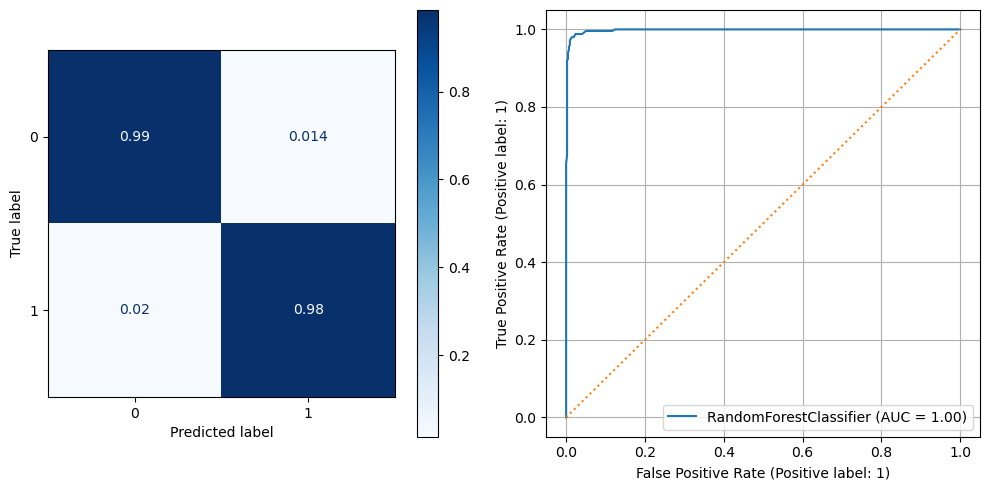

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       130
           1       0.80      0.84      0.82        93

    accuracy                           0.85       223
   macro avg       0.84      0.85      0.84       223
weighted avg       0.85      0.85      0.85       223



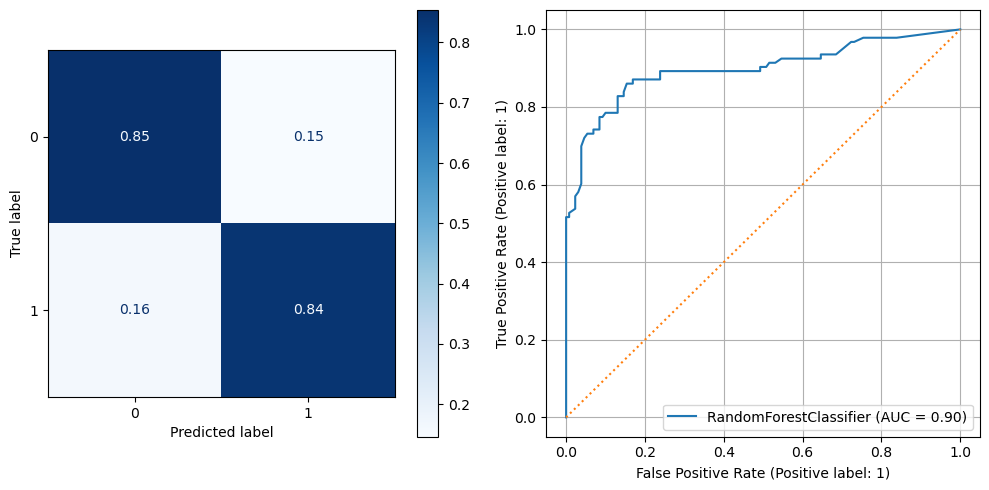

In [7]:
# evaluate the model
evaluate_classification(rf_clf, X_train_df, y_train, X_test_df, y_test)

- The model was 85% accurate for making correct predictions on the test set.
- The model was 88% sensitive and 85% specific for predicting the no survival class.
- The model was 80% sensitive and 84% specific for predicting the survival class.
- The model had f1-scores of 87% for the no survival class and 82% for the survival class.

## SHAP

### Import shap and initialize javascript

In [8]:
import shap
shap.initjs()

### Prepare the Data

In [9]:
len(X_train_df)

668

In [10]:
# sample a subset of the data
X_shap = shap.sample(X_train_df, nsamples = 400, random_state = 321)

In [11]:
# use the index of X_shap to slice out the corresponding y-data 
y_shap = y_train.loc[X_shap.index]

### Create a SHAP explainer

In [12]:
explainer = shap.Explainer(rf_clf)
explainer

### Get SHAP values from explainer for the training data

In [13]:
shap_values = explainer(X_shap, y_shap)
type(shap_values)

shap._explanation.Explanation

In [14]:
shap_values.shape

(400, 10, 2)

In [15]:
shap_values[0]

.values =
array([[ 4.80790553e-02, -4.80790553e-02],
       [-9.89255329e-03,  9.89255329e-03],
       [-1.03514577e-03,  1.03514577e-03],
       [ 3.18458789e-03, -3.18458789e-03],
       [ 1.30262326e-01, -1.30262326e-01],
       [ 1.68747685e-01, -1.68747685e-01],
       [ 1.11824866e-02, -1.11824866e-02],
       [ 2.05926536e-05, -2.05926536e-05],
       [ 6.06505137e-03, -6.06505137e-03],
       [ 1.61853154e-02, -1.61853154e-02]])

.base_values =
array([0.6272006, 0.3727994])

.data =
array([ 3.    , 26.    ,  0.    ,  0.    ,  7.8875,  1.    ,  0.    ,
        0.    ,  0.    ,  1.    ])

#### Limit the SHAP Values to one class

In [16]:
# slice for surviving values 
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 10)

In [17]:
# view in a dataframe
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
0,-0.048079,0.009893,0.001035,-0.003185,-0.130262,-0.168748,-0.011182,-0.000021,-0.006065,-0.016185
1,-0.061347,-0.032177,0.005746,-0.005985,-0.039690,-0.190839,-0.019228,-0.000032,-0.002342,-0.016907
2,-0.077390,-0.000850,-0.006068,-0.007766,0.004269,-0.223883,-0.021522,-0.000055,0.000974,-0.010507
3,-0.062288,0.054348,0.007510,0.015000,0.024125,0.352102,0.000244,-0.000040,-0.001053,0.012810
4,0.135682,-0.021898,0.047362,0.002270,0.020714,0.430389,-0.003929,-0.000037,0.004021,0.002626
...,...,...,...,...,...,...,...,...,...,...
395,-0.202651,-0.090436,0.013810,-0.146538,-0.010546,0.160788,-0.019809,-0.000064,0.001253,-0.018605
396,0.124108,0.023799,0.031882,0.013949,0.080248,0.273016,0.041850,-0.000046,0.001135,0.027260
397,0.160499,-0.040740,0.028569,0.002734,0.137565,0.264809,0.047525,-0.000032,0.004279,0.021991
398,-0.072344,-0.043803,-0.011707,-0.007556,-0.079463,-0.121605,-0.016025,-0.000023,-0.002483,-0.017789


### Summary Plot - Bar

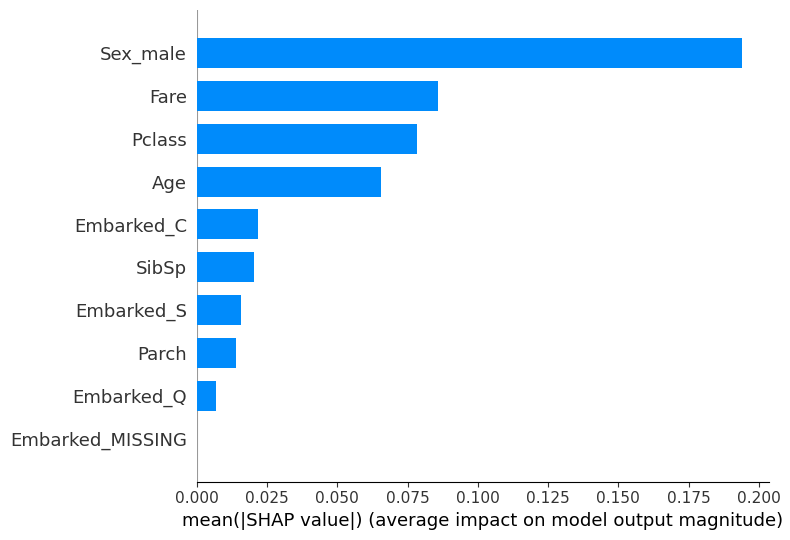

In [18]:
shap.summary_plot(shap_vals_1, features = X_shap, plot_type = 'bar')

### Summary Plot - dot

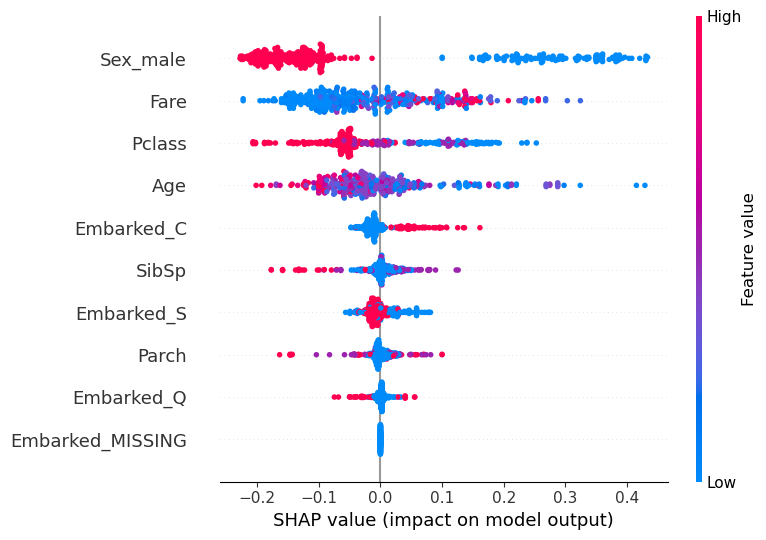

In [20]:
shap.summary_plot(shap_vals_1, X_shap)

### Interpret the 5 most important features

#### Sex_male
- The red values are on the left (negative).  If the passenger is male, then the model is less likely to predict survival.
- The blue values are on the right (positive).  If the passenger is female, then the model is more likely to predict the passenger will survive.

#### Fare
- The red values are on the right (positive).  The greater the ticket fare, the more likely the model would predict the passenger will survive.
- The blue values are on the left (negative).  The lower the ticket fare, the less likely the model will predict the passenger will survive.

#### Pclass
- The red values are on the left (negative).  If the passenger has a third class ticket, then the model is less likely to predict survival.
- The blue values are on the right (positive).  If the passenger has a first class ticket, then the model is more likely to predict the passenger will survive.

#### Age
- The red values are on the left (negative).  The older the age, the less likely the model would predict the passenger will survive.
- The blue values are on the right (positive).  The younger the passenger, the more likely the model would predict the passenger will survive.

#### Embarked_C
- The red values are on the right (positive).  If the passenger embarked in Cherbourg, then the model is more likely to predict the passenger will survive.
- The blue values are on the left (negative).  If the passenger did not embark in Cherbourg, then the model is less likely to predict the passenger will survive.